## CAS Connection

### Connect to the Cas Server

In [1]:
import swat
s = swat.CAS(host, port)

# Document Classification
## Part 1: Network Analytics for Feature Engineering
In this notebook, you will build a neural network model to perform a classification task. The example presented illustrates the advantage of using network analysics to construct additional features from connected data.

A different, but comparable method for incorporating network connectivity (using the same data set) is presented in the TensorFlow blog article [Graph regularization for document classification using natural graphs](https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_mlp_cora). However, the feature engineering approach presented in this notebook achieves higher prediction accuracy than the graph regularization approach presented in that article.

# Load Data

The Cora data set is publicly available via [this hyperlink](https://linqs.soe.ucsc.edu/data).

The data set represents a set of papers, listed in the file cora.content along with 1433 flag columns. Each column indicates whether each paper contains a particular word.

The second file, cora.cites, contains pairs of papers, in which the first paper cites the second.

In [2]:
import document_classification_scripts as scripts
import importlib
importlib.reload(scripts)
from document_classification_scripts import AttributeDict, nClasses, nWords, targetColumn, baseFeatureList
demo = scripts.Demo(s)

NOTE: Added action set 'sampling'.
NOTE: Added action set 'pca'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'network'.
NOTE: Added action set 'transpose'.
NOTE: Added action set 'table'.
NOTE: Added action set 'builtins'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'session'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'aStore'.
NOTE: Added action set 'aggregation'.


In [3]:
def loadRawData(pathCoraContent="../data/cora.content",
                pathCoraCites="../data/cora.cites"
                ):
    contentDf = pd.read_csv(pathCoraContent, sep="\t", header=None)
    contentDf.rename(columns=(lambda x: f"w{x}"), inplace=True)
    contentDf.rename(
        columns={
            "w0": "node",
            "w1434": "target"},
        inplace=True)
    s.upload(contentDf, casout={"name": "content", "replace": True})

    citesDf = pd.read_csv(pathCoraCites, sep="\t", header=None)
    citesDf.rename(columns={0: "from", 1: "to"}, inplace=True)
    s.upload(citesDf, casout={"name": "cites", "replace": True})

In [4]:
demo.loadRawData()

NOTE: Cloud Analytic Services made the uploaded file available as table CONTENT in caslib CASUSER(brrees).
NOTE: The table CONTENT has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table CITES in caslib CASUSER(brrees).
NOTE: The table CITES has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.


In [5]:
def head(table, nRows=5):
    return s.table.fetch(
        table=table,
        format=True,
        to=nRows,
        maxRows=nRows)

In [6]:
demo.head("content")

,node,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,w1433,target
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [7]:
demo.head("cites")

,from,to
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


### Graph Visualization Code

In [8]:
def graph2dot(linksDf=None,
        nodesDf=None,
        linksFrom="from",
        linksTo="to",
        nodesNode="node",
        nodesLabel=None,
        nodesSize=None,
        nodesSizeScale=1,
        nodesColor=None,
        linksLabel=None,
        linksColor=None,
        outFile=None,
        view=True,
        stdout=None,
        size=10,
        layout=None,
        directed=False,
        sort=True):
    dot = Digraph() if directed else Graph()
    dot.attr(rankdir='LR')
    dot.attr(size=f"{size}")
    dot.attr('node', shape='circle')
    if layout is not None:
        dot.attr(layout=f"{layout}")

    if(linksDf):
        for index, row in (linksDf.sort(
                [linksFrom, linksTo]).iterrows() if sort else linksDf.iterrows()):
            dot.edge(
                f"{row[linksFrom]}", f"{row[linksTo]}", label=None if (
                    linksLabel is None) else f"{row[linksLabel]}", color=None if (
                    linksColor is None) else row[linksColor])

    if(nodesDf):
        for index, row in (
            nodesDf.sort(
                [nodesNode]).iterrows() if sort else nodesDf.iterrows()):
            dot.node(
                f"{row[nodesNode]}",
                f"{row[nodesNode]}" if nodesLabel is None else f"{row[nodesLabel]}",
                width=None if (
                    nodesSize is None) else f"{1*nodesSizeScale*row[nodesSize]}",
                color=None if (
                    linksColor is None) else row[linksColor])
    if stdout is None:
        stdout = True if outFile is None else False
    if stdout:
        print(dot.source)
    if outFile is not None:
        dot.render(f"../dot/{outFile}", view=view)
    return dot

def showReachNeighborhood(session,
                          tableLinks,
                          tableNodes,
                          node,
                          hops,
                          directed=False,
                          size=5,
                          layout="fdp",
                          nodesSizeScale=100
                          ):
    nodeSub = {
        "node": [node],
        "reach": [1]
    }
    nodeSubDf = pd.DataFrame(nodeSub, columns=["node", "reach"])
    session.upload(nodeSubDf, casout={"name": "_nodeSub_", "replace": True})
    session.network.reach(
        loglevel="NONE",
        direction="directed" if directed else "undirected",
        links=tableLinks,
        nodes=tableNodes,
        nodesVar={"vars": ["target"]},
        maxReach=hops,
        outReachLinks={"name": "_reachLinks_", "replace": True},
        outReachNodes={"name": "_reachNodes_", "replace": True},
        nodesSubset="_nodeSub_"
    )
    session.datastep.runCode(
        code=f"""
         data _reachNodes_;
            set _reachNodes_;
            length label $50;
            label=target || "\nPaperId = " || put(node, 7.);
            if put(node, 7.) = {node} then label = "???" || "\nPaperId = " || put(node, 7.);
         run;
      """
    )
    return graph2dot(linksDf=session.CASTable("_reachLinks_"),
                     nodesDf=session.CASTable("_reachNodes_"),
                     nodesLabel="label",
                     layout=layout,
                     directed=directed,
                     size=size,
                     nodesSizeScale=nodesSizeScale,
                     stdout=False)

### Graph Visualization

NOTE: Cloud Analytic Services made the uploaded file available as table _NODESUB_ in caslib CASUSER(brrees).
NOTE: The table _NODESUB_ has been created in caslib CASUSER(brrees) from binary data uploaded to Cloud Analytic Services.
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:164
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 32 times)
      0:164  (occurred 32 times)


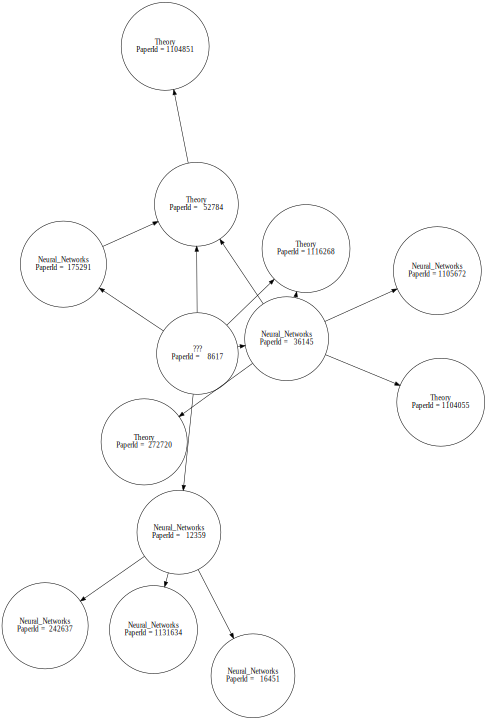

In [9]:
scripts.showReachNeighborhood(s,
                              "cites",
                              "content",
                              8617,
                              2,
                              directed=True,
                              size=10,
                              nodesSizeScale=5
                             )

# Data Preprocessing


## Create a custom format definition for target labels

In [10]:
def defineTargetVariableFormat():
    """Custom Format Definition for Target Labels."""
    s.sessionProp.addFmtLib(
        fmtLibName="myFmtLib",
        caslib="mycas",
        replace=True
    )
    s.sessionProp.addFormat(
        fmtLibName="myFmtLib",
        fmtName=targetClassFmt,
        replace=True,
        ranges={"'Case_Based'='1'",
                "'Genetic_Algorithms'='2'",
                "'Neural_Networks'='3'",
                "'Probabilistic_Methods'='4'",
                "'Reinforcement_Learning'='5'",
                "'Rule_Learning'='6'",
                "'Theory'='7'",
                "' '=' '"
                })

In [11]:
demo.defineTargetVariableFormat()

NOTE: Format library MYFMTLIB added. Format search update using parameter APPEND completed.


## Data Partitioning
Performs an 80%/20% training/test split. 

In [12]:
def addCaslibIfNeeded(caslib):
    r = s.table.queryCaslib(caslib=caslib)
    if not r[caslib]:
        s.table.addcaslib(
            activeOnAdd=False,
            caslib="cora",
            datasource={"srctype": "path"},
            path="/bigdisk/lax/brrees/data/cora"
        )

def saveTables(tables, caslib="cora", replace=True):
    for table in tables:
        s.table.save(
            caslib=caslib,
            table=table,
            name=f"{table}.sashdat",
            replace=replace
        )

def loadTables(tables, caslib="cora"):
    for table in tables:
        s.table.loadTable(
            caslib=caslib,
            casOut={"name": table, "replace": True},
            path=f"{table}.sashdat"
        )

def partitionData(tableIn="content",
        tableOut="contentPartitioned",
        tableTrainOut="contentTrain",
        tableTestOut="contentTest"):
    s.sampling.srs(
        table=tableIn,
        seed=randomSeed,
        samppct=trainPercentage,
        partInd=True,
        output={
            "casout": {"name": tableOut, "replace": True},
            "copyVars": "all",
            "partIndName": "partition"
        }
    )

    s.datastep.runCode(
        code=f"""
        data {tableTrainOut} {tableTestOut};
           set {tableOut};
           if partition=1 then output {tableTrainOut};
           else output {tableTestOut};
        run;
     """
    )

def loadOrPartitionData(newRun=False):
    coraCaslib = "cora"
    addCaslibIfNeeded(coraCaslib)

    r = s.table.fileInfo(caslib=coraCaslib)
    if "contentPartitioned.sashdat" not in r.FileInfo["Name"].unique():
        newRun = True

    if newRun:
        partitionData()
        saveTables(
            ["contentPartitioned", "contentTrain", "contentTest"])
    else:
        loadTables(
            ["contentPartitioned", "contentTrain", "contentTest"])

In [13]:
demo.loadOrPartitionData()
print(f"contentTrain: (rows, cols) = {s.CASTable('contentTrain').shape}")
print(f"contentTest:  (rows, cols) = {s.CASTable('contentTest').shape}")

NOTE: Cloud Analytic Services added the caslib 'cora'.
NOTE: Cloud Analytic Services made the file contentPartitioned.sashdat available as table CONTENTPARTITIONED in caslib CASUSER(brrees).
NOTE: Cloud Analytic Services made the file contentTrain.sashdat available as table CONTENTTRAIN in caslib CASUSER(brrees).
NOTE: Cloud Analytic Services made the file contentTest.sashdat available as table CONTENTTEST in caslib CASUSER(brrees).
contentTrain: (rows, cols) = (2166, 1436)
contentTest:  (rows, cols) = (542, 1436)


## Principal Component Analysis (PCA)
It is often useful to perform Principal Component Analysis on wide data. The eigenvalue PCA method in the pca action set allows you to keep only the components that contain the largest eigenvalues. This means the limited number of selected PCA variables can compactly represent most of the variation observed in the original wide data set.

In [14]:
def performPca(nPca):
    nPca = nPca
    s.pca.eig(
        table="contentTrain",
        n=nPca,
        prefix="pca",
        inputs=baseFeatureList,
        code={
            "casOut": {"name": "pcaTransformCode", "replace": True},
            "comment": False,
            "tabForm": True
        },
        output={"casOut": {"name": "contentTrainPca", "replace": True},
                "copyVars": ["node", "target", "partition"],
                "score": "pca"}
    )
    s.datastep.runCodeTable(
        table="contentPartitioned",
        codeTable="pcaTransformCode",
        casout={"name": "contentPartitionedPca"},
        dropVars=baseFeatureList
    )
    s.datastep.runCode(
        code="data contentTestPca; set contentPartitionedPca(where=(partition=0)); run;")

In [15]:
nPca = 40
demo.performPca(nPca)
pcaFeatureList = [f"pca{i}" for i in range(1,nPca)]

## Join Citations and Training Targets
By executing a join query, you can join the training target information to the citation links data. This allows you to partition the graph into subgraphs based on the type of paper being cited.

In [16]:
def joinTrainingTargets():
    s.fedsql.execDirect(
        query="""
  create table citesTrain {options replace=true} as
  select a.*, b.target as from_target, c.target as to_target
  from cites as a
  inner join contentTrain as b
  on a.from = b.node
  inner join contentTrain as c
  on a.to = c.node;
     """
    )
    s.fedsql.execDirect(
        query="""
  create table citesCombined {options replace=true} as
  select a.*, b.target as from_target, c.target as to_target
  from cites as a
  left join contentTrain as b
  on a.from = b.node
  left join contentTrain as c
  on a.to = c.node;
     """
    )

In [17]:
demo.joinTrainingTargets()

NOTE: Table CITESTRAIN was created in caslib CASUSER(brrees) with 3562 rows returned.
NOTE: Table CITESCOMBINED was created in caslib CASUSER(brrees) with 5429 rows returned.


## Generate Network Features

You can perform feature engineering using the network action set. The following code defines functions that:

- initialize the nodes table for your network by copying the content data table
- load the nodes and links tables into an in-memory graph object
- add features generated from each of the network actions considered:
    - centrality
    - community
    - core 
    - nodeSimilarity
- merge the new features into the nodes table as they are generated
- unload the in-memory graph object

Once these network features are generated, they are available to augment the classification model building process.

In [18]:
def initNetwork(tableName):
    # Copies the base feature table and returns an empty network features
    # list
    s.datastep.runCode(
        code=f"data {tableName}Network; set {tableName}; run;"
    )
    featureList = []
    return featureList

def loadGraph(tableNodes, tableLinks):
    # Load an in-memory copy of the graph represented by the nodes and
    # links tables
    r = s.network.loadGraph(
        multilinks=False,
        links=tableLinks,
        nodes={
            "name": tableNodes,
            "computedVars": ("initialCommunity"),
            "computedVarsProgram": "initialCommunity = input(put(target, $targetClass.), 1.);"},
        nodesVar={
            "vars": ("initialCommunity")})
    return r.graph

def unloadGraph(graphId):
    r = s.network.unloadGraph(
        graph=graphId
    )
    return None

def mergeFeatures(tableNodes, tableNodesAdd, featureList, featureListAdd):
    s.datastep.runCode(
        code=f"""
        data {tableNodes};
            merge {tableNodes} {tableNodesAdd};
            by node;
        run;
    """
    )
    featureList = featureList + featureListAdd
    return featureList

def mergeRatioFeature(
        tableNodes,
        tableNodesAdd,
        featureList,
        featureAdd,
        denominator):
    s.datastep.runCode(
        code=f"""
        data {tableNodes};
              merge {tableNodes} {tableNodesAdd};
              by node;
              if ({denominator} GT 0) then {featureAdd} = {featureAdd}/{denominator};
              else {featureAdd}=0;
        run;
     """
    )
    featureList = featureList + [featureAdd]
    return featureList

def addFeaturesNodeSimilarity(graphId, tableNodes, featureList):
    nDimensions = 10
    outTableNodes = "outNodesNodeSim"
    s.network.nodesimilarity(
        loglevel="BASIC",
        graph=graphId,
        jaccard=False,
        vector=True,
        proximityOrder="second",
        nDimensions=nDimensions,
        nSamples=500000,
        convergenceThreshold=0.0001,
        outNodes={"name": outTableNodes, "replace": True}
    )
    newFeatures = [f"vec_{i}" for i in range(
        nDimensions)] + [f"ctx_{i}" for i in range(nDimensions)]
    featureList = mergeFeatures(
        tableNodes, outTableNodes, featureList, newFeatures)
    return featureList

def addFeaturesCore(graphId, tableNodes, tableLinks, featureList):
    nDimensions = 10
    outTableNodes = "outNodesCore"
    s.network.core(
        graph=graphId,
        outNodes={"name": outTableNodes, "replace": True}
    )
    newFeatures = ["core_out"]
    featureList = mergeFeatures(
        tableNodes, outTableNodes, featureList, newFeatures)

    subgraphs = ["Case_Based",
                 "Genetic_Algorithms",
                 "Neural_Networks",
                 "Probabilistic_Methods",
                 "Reinforcement_Learning",
                 "Rule_Learning",
                 "Theory"
                 ]

    for subgraph in subgraphs:
        s.network.core(
            nodes=tableNodes,
            links={
                "name": tableLinks,
                "where": f"from_target EQ '{subgraph}' OR to_target EQ '{subgraph}'"},
            outNodes={
                "name": outTableNodes,
                "replace": True})
        newFeature = "core_out_" + subgraph
        featureList = mergeRatioFeature(
            tableNodes,
            outTableNodes +
            f"(rename=(core_out={newFeature}))",
            featureList,
            newFeature,
            "core_out")
    return featureList

def addFeaturesCentrality(tableNodes, tableLinks, featureList):
    outTableNodes = "nodesCentrality"
    outTableTransIn = "nodesDegreeIn"
    outTableTransOut = "nodesDegreeOut"

    s.network.centrality(
        direction="directed",
        links={
            "name": tableLinks,
            "where": "from_target NE ' '",
            "groupBy": "from_target"},
        outNodes={
            "name": outTableNodes,
            "replace": True},
        degree="unweight")
    s.transpose.transpose(
        table={"name": outTableNodes, "groupBy": "node"},
        transpose=("centr_degree_in"),
        id=("from_target"),
        prefix="deg_in_",
        casOut={"name": outTableTransIn, "replace": True}
    )

    s.network.centrality(
        direction="directed",
        links={
            "name": tableLinks,
            "where": "to_target NE ' '",
            "groupBy": "to_target"},
        outNodes={
            "name": outTableNodes,
            "replace": True},
        degree="unweight")
    s.transpose.transpose(
        table={"name": outTableNodes, "groupBy": "node"},
        transpose=("centr_degree_out"),
        id=("to_target"),
        prefix="deg_out_",
        casOut={"name": outTableTransOut, "replace": True}
    )
    tableNetworkDegree = "networkDegree"
    s.datastep.runCode(
        code=f"""
        data networkDegree;
              merge {tableNodes}(keep=node)
                    {outTableTransIn}(drop=_NAME_)
                    {outTableTransOut}(drop=_NAME_);
              by node;
              array x deg_: ;
              do over x;
                 if x=. then x=0;
              end;
        run;
     """
    )
    r = s.table.columnInfo(
        table=tableNetworkDegree
    )
    newFeatures = r["ColumnInfo"]['Column'].tolist()[1:]
    featureList = mergeFeatures(
        tableNodes, tableNetworkDegree, featureList, newFeatures)
    return featureList

def addFeaturesCommunity(graphId, tableNodes, featureList):
    outTableNodes = "outNodesCommunity"
    outTableComm = "outComm"
    outTableOverlap = "OutCommOverlap"
    s.network.community(
        graph=graphId,
        warmstart="initialCommunity",
        resolutionList=(1.0, 0.2),
        outNodes={"name": outTableNodes, "replace": True}
    )
    s.network.community(
        graph=graphId,
        warmstart="initialCommunity",
        resolutionList=(1.0),
        outCommunity={"name": outTableComm, "replace": True},
        outOverlap={"name": outTableOverlap, "replace": True}
    )
    s.fedsql.execDirect(
        query=f"""
        create table {outTableNodes} {{options replace=true}} as
        select a.*, b.nodes as "commNodes",
                 b.conductance as "commConductance",
                 b.density as "commDensity",
                 COALESCE(c.intensity, 0) as "commIntensity"
        from {outTableNodes} as a
        left join {outTableComm} as b
        on a.community_0 = b.community and b.level = 0
        left join {outTableOverlap} as c
        on a.node=c.node and a.community_0 = c.community
        ;
     """
    )
    newFeatures = [
        "commNodes",
        "commConductance",
        "commDensity",
        "commIntensity"]
    featureList = mergeFeatures(
        tableNodes, outTableNodes, featureList, newFeatures)
    return featureList

def addNetworkFeatures(tableInitNodes, tableLinks, networkParam):
    tableNodes = f"{tableInitNodes}Network"
    featureList = initNetwork(tableInitNodes)
    if loadedGraph is None:
        loadedGraph = loadGraph(tableInitNodes, tableLinks)
    if networkParam.useCommunity:
        featureList = addFeaturesCommunity(
            loadedGraph, tableNodes, featureList)
    if networkParam.useCentrality:
        featureList = addFeaturesCentrality(
            tableNodes, tableLinks, featureList)
    if networkParam.useNodeSimilarity:
        featureList = addFeaturesNodeSimilarity(
            loadedGraph, tableNodes, featureList)
    if networkParam.useCore:
        featureList = addFeaturesCore(
            loadedGraph, tableNodes, tableLinks, featureList)
    if loadedGraph is not None:
        unloadGraph(loadedGraph)
        loadedGraph = None
    return (tableNodes, featureList)

Four tables are created {training, scoring} X {base, PCA}:
- for training, the graph is limited to links where both endpoints belong to the training data set
- for scoring, the whole graph is available (with missing target labels for the test data set)

The following cell adds Network features to each of these four tables.

In [19]:
%%capture
networkParam=AttributeDict({
    "useCentrality":True,
    "useNodeSimilarity":True,
    "useCommunity":True,
    "useCore":True
})

tableContentNetwork, networkFeatureList = demo.addNetworkFeatures(
    "contentTrain", "citesTrain", networkParam)
tableContentPartitionedNetwork, networkFeatureList = demo.addNetworkFeatures(
    "contentPartitioned", "citesCombined", networkParam)

tableContentNetworkPca, networkFeatureList = demo.addNetworkFeatures(
    "contentTrainPca", "citesTrain", networkParam)
tableContentPartitionedNetworkPca, networkFeatureList = demo.addNetworkFeatures(
    "contentPartitionedPca", "citesCombined", networkParam)

In [20]:
s.datastep.runCode(
    code = f"data contentTestNetwork; set {tableContentPartitionedNetwork}(where=(partition=0)); run;"
)
print(f"contentTestNetwork: (rows, cols) = {s.CASTable('contentTestNetwork').shape}")

s.datastep.runCode(
    code = f"data contentTestPcaNetwork; set {tableContentPartitionedNetworkPca}(where=(partition=0)); run;"
)
print(f"contentTestPcaNetwork: (rows, cols) = {s.CASTable('contentTestPcaNetwork').shape}")

contentTestNetwork: (rows, cols) = (542, 1485)
contentTestPcaNetwork: (rows, cols) = (542, 92)


# Build a Neural Network Classifier
## Define a Neural Net with Two Dense Hidden Layers

The neural network architechture to be trained has two dense hidden layers:
![nn_architecture.png](https://drive.google.com/uc?id=10BnPFGecbfkxkMMRiodt41n5xSj_Sq_F)

### deepLearn Hyperparameters

In [21]:
deepLearnParam = AttributeDict({
    "randomSeed": 456,
    "dropout": 0.5,
    "activation": "RECTIFIER",
    "outputActivation": "SOFTMAX",
    "denseLayers": [50,50],
    "nOutputs": nClasses,
    "nEpochs": 100,
    "algoMethod": "ADAM",
    "useLocking": False
})

## Train a Neural Net Model with Baseline Features

In [22]:
def defineNnModel(modelName, deepLearnParam):
    s.deepLearn.buildModel(
        modelTable={"name": modelName, "replace": True},
        type="DNN"
    )

    # Add the input layer
    s.deepLearn.addLayer(
        modelTable={"name": modelName},
        layer={"type": "INPUT"},
        name="inputLayer"
    )

    # Add the dense (a.k.a. fully connected) layers
    prevLayer = "inputLayer"
    for i in range(len(deepLearnParam.denseLayers)):
        thisLayer = f"denseLayer{i}"
        s.deepLearn.addLayer(
            modelTable={"name": modelName},
            layer={"type": "FC",
                   "n": deepLearnParam.denseLayers[i],
                   "act": deepLearnParam.activation,
                   "dropout": deepLearnParam.dropout},
            name=thisLayer,
            srcLayers=[prevLayer]
        )
        prevLayer = thisLayer

    # Add the output layer
    s.deepLearn.addLayer(
        modelTable={"name": modelName},
        layer={"type": "OUTPUT",
               "n": deepLearnParam.nOutputs,
               "act": deepLearnParam.outputActivation},
        name="outputLayer",
        srcLayers=[prevLayer]
    )

def trainNnModel(modelName, tableTrain, featureList, deepLearnParam):
    return s.deepLearn.dlTrain(
        seed=deepLearnParam.randomSeed,
        inputs=featureList,
        target=targetColumn,
        table=tableTrain,
        modelTable=modelName,
        optimizer={
            "algorithm": {
                "method": deepLearnParam.algoMethod,
                "useLocking": deepLearnParam.useLocking},
            "maxEpochs": deepLearnParam.nEpochs},
        modelWeights={
            "name": f"{modelName}Weights",
            "replace": True})

def scoreNnModel(modelName, tableTest, silent=False):
    r = s.deepLearn.dlScore(
        initWeights=f"{modelName}Weights",
        table=tableTest,
        modelTable=modelName,
        copyVars=("node", "target"),
        casOut={"name": f"{modelName}Scored", "replace": True}
    )
    accuracy = (100 - float(r.ScoreInfo["Value"][2])) / 100
    if not silent:
        print(r.ScoreInfo)
        print(f"Accuracy = {accuracy}")
    return accuracy

def bootstrapNnModel(modelName, tableTrain, tableTest, featureList, deepLearnParam, n):
  accuracies = []
  for i in range(n):
     partitionData(tableIn=tableTest, tableOut=f"{tableTest}Part_", table1Out=f"{tableTest}Boot_", table2Out=None, frac1=90, randomSeed=(i+5678), partName="bootstrap")
     trainNnModel(modelName, tableTrain, featureList, deepLearnParam)
     acc=scoreNnModel(modelName, f"{tableTest}Boot_", silent=True)
     print(f"Accuracy = {acc}")
     accuracies = accuracies + [acc]

  print(f"Bootstrap Accuracy = {np.mean(accuracies)} +- {np.std(accuracies)}")
  return accuracies

In [23]:
baseModel = "baseModel"
demo.defineNnModel(baseModel, deepLearnParam)

In [24]:
demo.trainNnModel(baseModel,"contentTrain", scripts.baseFeatureList, deepLearnParam)

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


,Descr,Value
0,Model Name,basemodel
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,74500
7,Number of Bias Parameters,107
8,Total Number of Model Parameters,74607
9,Approximate Memory Cost for Training (MB),4


In [25]:
demo.scoreNnModel(baseModel,"contentTest")

                         Descr         Value
0  Number of Observations Read           542
1  Number of Observations Used           542
2  Misclassification Error (%)      21.95572
3                   Loss Error      1.917275
Accuracy = 0.7804428


0.7804428

### Bootstrap Runs

In [26]:
accuracies = demo.bootstrapNnModel(baseModel,"contentTrain","contentTest",baseFeatureList, deepLearnParam, 25);

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5678 for sampling.
Accuracy = 0.7643442999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5679 for sampling.
Accuracy = 0.7848361
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5680 for sampling.
Accuracy = 0.7745902
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5681 for sampling.
Accuracy = 0.7745902
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5682 for sampling.
Accuracy = 0.7745902
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5683 for sampling.
Accuracy = 0.7745902
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5684 for sampling.
Accuracy = 0.7663934
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5685 for sampling.
Accuracy = 0.7889344
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5686 for sampling.
Accuracy = 0.7786884999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5687 for sampling.
Acc

## Train a Neural Net Model with PCA Features

In [27]:
pcaModel="pcaModel"
demo.defineNnModel(pcaModel, deepLearnParam)

In [28]:
demo.trainNnModel(pcaModel,"contentTrainPca", pcaFeatureList, deepLearnParam)

,Descr,Value
0,Model Name,pcamodel
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,4800
7,Number of Bias Parameters,107
8,Total Number of Model Parameters,4907
9,Approximate Memory Cost for Training (MB),1


### Score the PCA Features Model

In [29]:
demo.scoreNnModel(pcaModel,"contentTestPca")

                         Descr         Value
0  Number of Observations Read           542
1  Number of Observations Used           542
2  Misclassification Error (%)      26.01476
3                   Loss Error      0.765852
Accuracy = 0.7398524000000001


0.7398524000000001

### Bootstrap Runs

In [30]:
accuracies = demo.bootstrapNnModel(pcaModel,"contentTrainPca","contentTestPca",pcaFeatureList, deepLearnParam, 25);

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5678 for sampling.
Accuracy = 0.7336066
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5679 for sampling.
Accuracy = 0.7356557000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5680 for sampling.
Accuracy = 0.7438525
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5681 for sampling.
Accuracy = 0.7459015999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5682 for sampling.
Accuracy = 0.7459015999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5683 for sampling.
Accuracy = 0.7336066
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5684 for sampling.
Accuracy = 0.7418032999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5685 for sampling.
Accuracy = 0.7315574000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5686 for sampling.
Accuracy = 0.7459015999999999
NOTE: Simple Random Sampling is in effect.
NOT

## Train a Model that includes Only Network Features

In [31]:
networkOnlyModel = "networkOnlyModel"
demo.defineNnModel(networkOnlyModel, deepLearnParam)

In [32]:
demo.trainNnModel(networkOnlyModel,"contentTrainNetwork",networkFeatureList, deepLearnParam)

,Descr,Value
0,Model Name,networkonlymodel
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,5150
7,Number of Bias Parameters,107
8,Total Number of Model Parameters,5257
9,Approximate Memory Cost for Training (MB),1


### Score the Network-Only Model

In [33]:
demo.scoreNnModel(networkOnlyModel,"contentTestNetwork")

                         Descr         Value
0  Number of Observations Read           542
1  Number of Observations Used           542
2  Misclassification Error (%)      14.02214
3                   Loss Error      0.622495
Accuracy = 0.8597786


0.8597786

### Bootstrap Runs

In [34]:
demo.bootstrapNnModel(networkOnlyModel,tableContentNetwork,"contentTestNetwork",networkFeatureList, deepLearnParam, 25);

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5678 for sampling.
Accuracy = 0.8688525
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5679 for sampling.
Accuracy = 0.8606556999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5680 for sampling.
Accuracy = 0.8606556999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5681 for sampling.
Accuracy = 0.8668032999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5682 for sampling.
Accuracy = 0.8668032999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5683 for sampling.
Accuracy = 0.8688525
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5684 for sampling.
Accuracy = 0.8586066
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5685 for sampling.
Accuracy = 0.8627049
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5686 for sampling.
Accuracy = 0.875
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5687 for

## Train a Neural Net Model with Baseline + Network Features

In [35]:
networkModel = "networkModel"
demo.defineNnModel(networkModel, deepLearnParam)

In [36]:
demo.trainNnModel(networkModel,"contentTrainNetwork",baseFeatureList+networkFeatureList, deepLearnParam)

,Descr,Value
0,Model Name,networkmodel
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,76800
7,Number of Bias Parameters,107
8,Total Number of Model Parameters,76907
9,Approximate Memory Cost for Training (MB),4


### Score the Baseline+Network Model

In [37]:
demo.scoreNnModel(networkModel,"contentTestNetwork")

                         Descr         Value
0  Number of Observations Read           542
1  Number of Observations Used           542
2  Misclassification Error (%)      11.43911
3                   Loss Error      0.937649
Accuracy = 0.8856089


0.8856089

### Bootstrap Runs

In [38]:
demo.bootstrapNnModel(networkModel,"contentTrainNetwork","contentTestNetwork",baseFeatureList+networkFeatureList, deepLearnParam, 25);

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5678 for sampling.
Accuracy = 0.8688525
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5679 for sampling.
Accuracy = 0.8299179999999999
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5680 for sampling.
Accuracy = 0.8483607000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5681 for sampling.
Accuracy = 0.8586066
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5682 for sampling.
Accuracy = 0.8647541
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5683 for sampling.
Accuracy = 0.8442623
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5684 for sampling.
Accuracy = 0.8627049
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5685 for sampling.
Accuracy = 0.8790984000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5686 for sampling.
Accuracy = 0.8934426000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5687

## Train a Neural Net Model with PCA + Network Features

In [39]:
networkPcaModel = "networkPcaModel"
demo.defineNnModel(networkPcaModel, deepLearnParam)

In [40]:
demo.trainNnModel(networkPcaModel,"contentTrainPcaNetwork",pcaFeatureList+networkFeatureList, deepLearnParam)

,Descr,Value
0,Model Name,networkpcamodel
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,7100
7,Number of Bias Parameters,107
8,Total Number of Model Parameters,7207
9,Approximate Memory Cost for Training (MB),1


### Score the PCA + Network Model

In [41]:
demo.scoreNnModel(networkPcaModel,"contentTestPcaNetwork")

                         Descr         Value
0  Number of Observations Read           542
1  Number of Observations Used           542
2  Misclassification Error (%)      11.43911
3                   Loss Error      0.493904
Accuracy = 0.8856089


0.8856089

### Bootstrap Runs

In [42]:
demo.bootstrapNnModel(networkPcaModel,"contentTrainPcaNetwork","contentTestPcaNetwork",pcaFeatureList+networkFeatureList, deepLearnParam, 25);

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5678 for sampling.
Accuracy = 0.8872951
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5679 for sampling.
Accuracy = 0.8688525
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5680 for sampling.
Accuracy = 0.8852459
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5681 for sampling.
Accuracy = 0.8729508
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5682 for sampling.
Accuracy = 0.8790984000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5683 for sampling.
Accuracy = 0.8831967000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5684 for sampling.
Accuracy = 0.8770492
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5685 for sampling.
Accuracy = 0.8995902
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5686 for sampling.
Accuracy = 0.8831967000000001
NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=5687 for samp

# Session Cleanup

In [43]:
s.terminate();